In [8]:
import json
import requests 
import networkx as nx
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

In [11]:
start_time = time.time()
print("Starting at " + str(datetime.datetime.now()))

api_base_url = 'https://api.coindesk.com/v1/bpi/historical/close.json'
start_date='2017-09-01'
end_date='2018-03-30'
params='?start=' + start_date + '&end=' + end_date

url = api_base_url + params
print("URL:", url)

r = requests.get(url = url)
if r.status_code == 200:
    prices_json_obj = json.loads(r.text)
    prices_dic = prices_json_obj['bpi']

print("Finished at " + str(datetime.datetime.now()))
print("Total time: --- {0} seconds ---".format(round(time.time() - start_time, 4)))

Starting at 2019-10-01 16:54:17.884004
URL: https://api.coindesk.com/v1/bpi/historical/close.json?start=2017-09-01&end=2018-03-30
Finished at 2019-10-01 16:54:17.963569
Total time: --- 0.0798 seconds ---


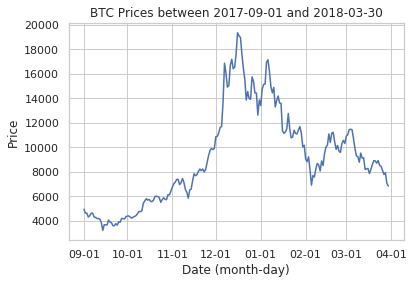

In [53]:
import matplotlib.dates as mdates

Y = list(map(lambda x: datetime.datetime.strptime(x, "%Y-%m-%d").date(), prices_dic.keys()))

fig, ax = plt.subplots()
ax.plot(Y, prices_dic.values())
plt.xlabel('Date (month-day)')
plt.ylabel('Price')
plt.title('BTC Prices between ' + start_date + ' and ' + end_date)

format_xdata = mdates.DateFormatter('%m-%d')

#max_yticks = 8
#xloc = plt.MaxNLocator(max_yticks)
#ax.xaxis.set_major_locator(xloc)
ax.xaxis.set_major_formatter(format_xdata)


plt.show()

In [57]:
import networkx as nx

In [71]:
cascades = nx.read_edgelist("cascades_bitcoin_20170901_20180330.edgelist", 
                            create_using=nx.DiGraph(),
                           data=(('created_utc',int),('type',str), ('subreddit',str), ('author',str)))

In [74]:
cascades = nx.read_gpickle("cascades_bitcoin_20170801_20180430.gpickle")

In [67]:
start_time = time.time()
print("Starting at " + str(datetime.datetime.now()))

components = list(nx.weakly_connected_components(cascades))
cascades_count=0


print("Found", len(components), "components")

for day in Y:
    volume_of_cascades = []
    for i, c in enumerate(components) :
        c_subgraph = cascades.subgraph(c)

        root_post_id, root_epoch = None, 0
        authors_set = set()

        for (node, val) in c_subgraph.out_degree():
            creeated_date = datetime.datetime.utcfromtimestamp(c_subgraph.nodes[node]['created_utc']).date()
            
            if created_date >= day and reated_date < day + datetime.timedelta(days=1):
                if val == 0 and 'type' in c_subgraph.nodes[node] and c_subgraph.nodes[node]['type'] == 's':
                    root_post_id = node
                    if 'author' in c_subgraph.nodes[node]:
                        authors_set.add(c_subgraph.nodes[node]['author'])
                    break

        if root_post_id is None:
            continue

        if 'created_utc' in c_subgraph.nodes[root_post_id]:
            root_epoch = int(c_subgraph.nodes[root_post_id]['created_utc'])

        first_c, first_c_epoch = None, 1569968106
        last_c, last_c_epoch = None, 0

        node_dreated_date = None
        for n in c_subgraph.predecessors(root_post_id):
            if 'created_utc' in c_subgraph.nodes[n]:
                epoch = int(c_subgraph.nodes[n]['created_utc'])
                node_created_date = datetime.datetime.utcfromtimestamp(c_subgraph.nodes[node]['created_utc']).date()

            if 'author' in c_subgraph.nodes[n] and node_created_date and \
            node_created_date >= day and node_created_date < day + datetime.timedelta(days=1) :
                authors_set.add(c_subgraph.nodes[n]['author'])

            #find first comment
            if epoch < first_c_epoch:
                first_c, first_c_epoch = n, epoch

        #Initial delay
        if root_post_id is not None and first_c is not None:
            initial_delay = first_c_epoch - root_epoch

            if initial_delay < 0:
                negative_initial_delay_cascade_counter += 1
                continue

            #It is a cascade!! There's an initial post, first comment, and the initial delay is non-negative
            cascades_count += 1
            audience_size_of_cascades.append(len(authors_set))    
            
            
    print("Audience Size (unique users) for day: ", day)
    print("\t Mean:", round(mean(audience_size_of_cascades), 2))
    print("\t Median:", round(median(audience_size_of_cascades), 2))
    print("\t Max:", max(audience_size_of_cascades))
    print("\t Min:", min(audience_size_of_cascades))

    
#         if cascades_count % 5000 == 0:
#             print(cascades_count+1, "th cascade; root node:", root_post_id, root_epoch,
#                   "First comment:", first_c, first_c_epoch, "Initial delay:", initial_delay)

print("Finished at " + str(datetime.datetime.now()))
print("Total time: --- {0} seconds ---".format(round(time.time() - start_time, 4)))

Starting at 2019-10-04 11:07:51.311252
Found 120895 components


KeyError: 'created_utc'